# 特徴量エンジニアリング

In [4]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import dask.array as da

In [5]:
DATAPATH = "../../../data/DBLP/made/"

In [6]:
with open(DATAPATH + "keywords_delete_similar_words.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2275, '3d imaging')

In [7]:
word_dict = {}
for num, kw in enumerate(keywords):
    word_dict[kw] = num

In [8]:
N = len(keywords)
START_YEAR = 2000
END_YEAR   = 2020
YEAR_STD   = END_YEAR - START_YEAR 

In [9]:
pathes = np.load(DATAPATH+"pathes.npy")
pathes.shape

(2275, 2275, 21)

In [10]:
STD = 5
pathes_s1, pathes_s2, pathes_s3 = pathes[:,:,:-STD], pathes[:,:,:-STD-1], pathes[:,:,:-STD-2]
pathes_s1.shape, pathes_s2.shape, pathes_s3.shape

((2275, 2275, 16), (2275, 2275, 15), (2275, 2275, 14))

## 隣接行列の作成

In [11]:
pathes_sum1 = np.sum(pathes_s1, axis=2)
pathes_sum2 = np.sum(pathes_s2, axis=2)
pathes_sum3 = np.sum(pathes_s3, axis=2)
# 厳密な隣接行列ではない
adj = np.where(pathes_sum1 <= 0, 0, 1)
adj_ex2, adj_ex3 = np.where(pathes_sum2 <= 0, 0, 1), np.where(pathes_sum3 <= 0, 0, 1)
adj.shape

(2275, 2275)

## 次数の計算

In [12]:
degs1 = np.sum(adj, axis=0)
degs2 = np.sum(adj, axis=1)
degs = degs1 + degs2
degs.shape

(2275,)

In [13]:
degs1 = np.tile( degs, (N, 1))
degs2 = degs1.T
degs1.shape, degs2.shape

((2275, 2275), (2275, 2275))

In [14]:
keyword_dict = {}
for deg, kw in zip(degs, keywords):
    keyword_dict[kw] = deg

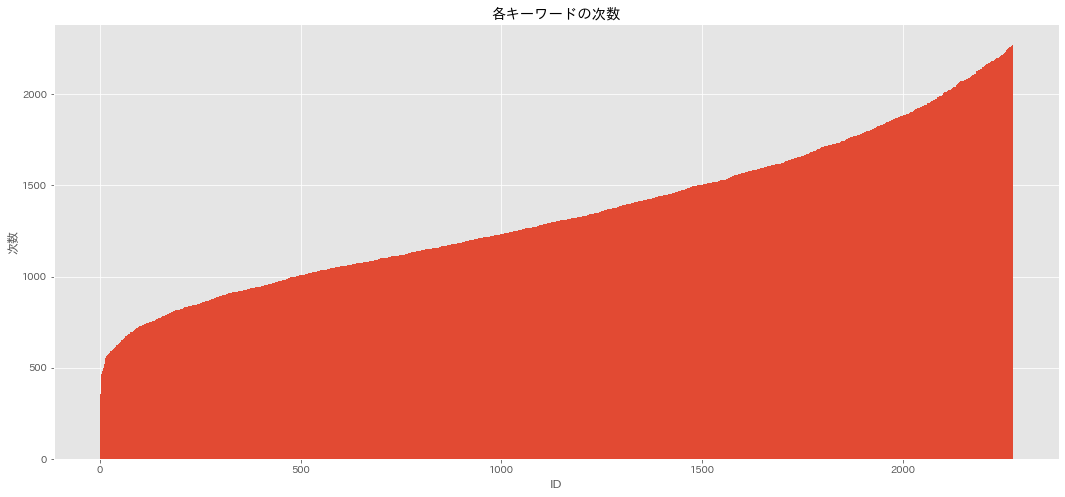

In [15]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("各キーワードの次数")
ax.set_xlabel("ID")
ax.set_ylabel("次数")

# Axesに棒グラフを追加
ax.bar(range(N), sorted(degs), width=1)

plt.show()

## 論文数

In [16]:
papers1 = np.sum(pathes_sum1, axis=0)
papers2 = np.sum(pathes_sum1, axis=1)
papers = papers1 + papers2
papers.shape

(2275,)

In [17]:
papers1 = np.tile( papers, (N, 1))
papers2 = papers1.T
papers1.shape, papers2.shape

((2275, 2275), (2275, 2275))

In [18]:
papers_dict = {}
for paper, kw in zip(papers, keywords):
    keyword_dict[kw] = paper

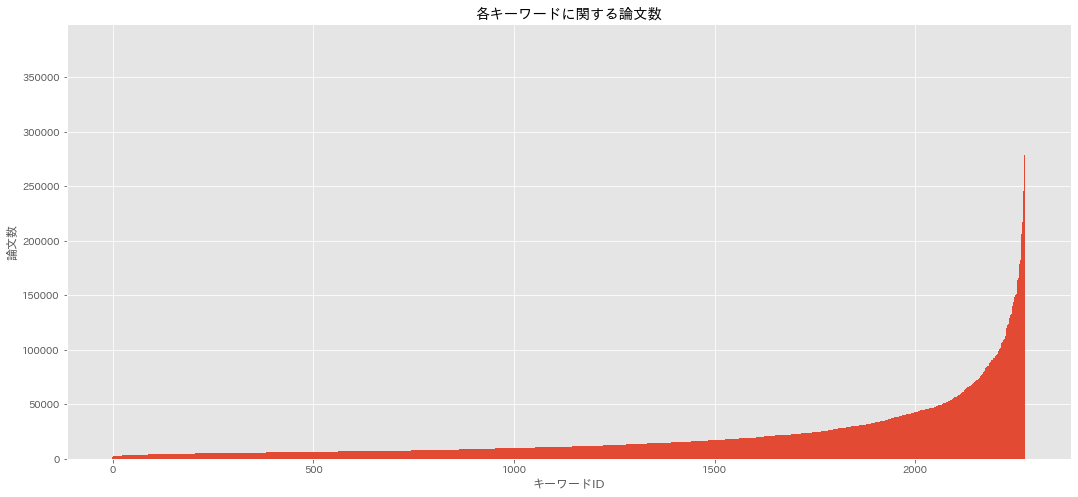

In [19]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("各キーワードに関する論文数")
ax.set_xlabel("キーワードID")
ax.set_ylabel("論文数")

# Axesに棒グラフを追加
ax.bar(range(N), sorted(papers), width=1)

plt.show()

## 距離n(=2,3,4)のノード数
隣接行列の冪乗(n乗)は、距離nである各点から他の点までのルート数を表すことを利用する

In [20]:
adj = adj + adj.T
print("グラフの密度は、{}".format(round(np.sum(adj) / len(adj) / len(adj), 3)))

グラフの密度は、0.591


かなり密なグラフ

In [21]:
adj

array([[0, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
%%time
def dadot(arr, p):
    darr = da.from_array(arr, chunks=(1000,1000))
    dadot = da.dot(darr, darr)
    return dadot.compute()

dadot(adj, 2)

CPU times: user 47.7 s, sys: 536 ms, total: 48.2 s
Wall time: 10.4 s


array([[1064,  791,  707, ...,  556,  439,  459],
       [ 791, 1075,  721, ...,  560,  435,  467],
       [ 707,  721, 1058, ...,  610,  513,  473],
       ...,
       [ 556,  560,  610, ..., 1061,  694,  424],
       [ 439,  435,  513, ...,  694,  820,  347],
       [ 459,  467,  473, ...,  424,  347,  955]])

In [23]:
%%time
np.linalg.matrix_power(adj, 2)

CPU times: user 1min 10s, sys: 128 ms, total: 1min 11s
Wall time: 1min 11s


array([[1064,  791,  707, ...,  556,  439,  459],
       [ 791, 1075,  721, ...,  560,  435,  467],
       [ 707,  721, 1058, ...,  610,  513,  473],
       ...,
       [ 556,  560,  610, ..., 1061,  694,  424],
       [ 439,  435,  513, ...,  694,  820,  347],
       [ 459,  467,  473, ...,  424,  347,  955]])

In [24]:

%%time
adj2 = dadot(adj, 2)
adj3 = dadot(adj, 3)
adj4 = dadot(adj, 4)

CPU times: user 2min 25s, sys: 1.22 s, total: 2min 26s
Wall time: 31.6 s


In [25]:
adj_ex2 = adj_ex2 + adj_ex2.T
adj2_ex1 = dadot(adj_ex2, 2)
adj3_ex1 = dadot(adj_ex2, 3)
adj4_ex1 = dadot(adj_ex2, 4)

In [26]:
adj_ex3 = adj_ex3 + adj_ex3.T
adj2_ex2 = dadot(adj_ex3, 2)
adj3_ex2 = dadot(adj_ex3, 3)
adj4_ex2 = dadot(adj_ex3, 4)

## 距離
各ノード間の距離を求める

In [27]:
import numpy as np
from scipy.sparse.csgraph import shortest_path, floyd_warshall, dijkstra, bellman_ford, johnson
from scipy.sparse import csr_matrix

In [28]:
%%time
distances = shortest_path(adj)
distances.shape

CPU times: user 13.4 s, sys: 180 ms, total: 13.6 s
Wall time: 13.6 s


(2275, 2275)

In [29]:
pathes_sum = pathes_sum1 + pathes_sum1.T
distances2 = shortest_path(np.array(pathes_sum))
distances2.shape

(2275, 2275)

In [30]:
degs = degs.reshape([1,-1])
diss = degs.T.dot(degs)
diss.shape

(2275, 2275)

In [31]:
diss_sqrt = np.sqrt(diss)
diss_sqrt.shape

(2275, 2275)

In [32]:
distances3 = distances * diss
distances4 = distances * diss_sqrt

## コサイン類似度

In [33]:
cosine_sim = adj2 / diss_sqrt
cosine_sim.shape

(2275, 2275)

# 標準化

In [34]:
degs1 = degs1 / np.max(degs1)
degs2 = degs2 / np.max(degs2)

In [35]:
papers1 = papers1 / np.max(papers1)
papers2 = papers2 / np.max(papers2)

In [36]:
adj2 = adj2 / np.max(adj2)
adj3 = adj3 / np.max(adj3)
adj4 = adj4 / np.max(adj4)

In [37]:
adj2_ex1 = adj2_ex1 / np.max(adj2_ex1)
adj3_ex1 = adj3_ex1 / np.max(adj3_ex1)
adj4_ex1 = adj4_ex1 / np.max(adj4_ex1)

In [38]:
adj2_ex2 = adj2_ex2 / np.max(adj2_ex2)
adj3_ex2 = adj3_ex2 / np.max(adj3_ex2)
adj4_ex2 = adj4_ex2 / np.max(adj4_ex2)

In [39]:
distances = distances / np.max(distances)
distances2 = distances2 / np.max(distances2)
distances3 = distances3 / np.max(distances3)
distances4 = distances4 / np.max(distances4)

## 目的変数
時を経つごとに、論文数が減っている

In [40]:
preds = pathes[:,:,-STD:]
preds_before = pathes[:,:,-STD-5:-STD]
preds.shape, preds_before.shape

((2275, 2275, 5), (2275, 2275, 5))

In [41]:
preds = np.sum(preds, axis=2)
preds_before = np.sum(preds_before, axis=2)
preds.shape, preds_before.shape

((2275, 2275), (2275, 2275))

In [42]:
p = preds.reshape(-1)
np.count_nonzero(p > 0) / N / N

0.04536031880207704

In [43]:
preds_before =  preds - preds_before
preds_before.shape

(2275, 2275)

# 特徴量

In [44]:
data = np.stack([
    degs1, degs2, 
    papers1, papers2, cosine_sim, 
    adj2, adj2_ex1, adj2_ex2,
    adj3, adj3_ex1, adj3_ex2, 
    adj4, adj4_ex1, adj4_ex2, 
    distances, distances2, distances3, distances4,
    pathes[:,:,-10],pathes[:,:,-9],pathes[:,:,-8],pathes[:,:,-7],pathes[:,:,-6],
], 2)
data.shape

(2275, 2275, 23)

In [45]:
np.save(DATAPATH + "test_x.npy", data)

In [46]:
np.save(DATAPATH + "test_y.npy", preds)
np.save(DATAPATH + "test_y_diff.npy", preds_before)